In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import tensorflow as tf
import time

from scipy.stats import gamma
from scipy.stats import lognorm
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

In [3]:
# Price for zero-coupon bond with stochastic interest rate under Vasicek's model
def ZC_Vasicek(F, r, kappa, theta, sigma, t, T):
    
    delta_T = T - t
    
    B = (1 - np.exp(-kappa * delta_T)) / kappa
    
    A = np.exp((theta - (sigma**2) / (2 * kappa**2)) * (B - delta_T) - (sigma**2 / (4 * kappa)) * B**2)
    
    bond_price = F * A * np.exp(-B * r)
    
    return bond_price

Probability of no default: 0.0292
0.9800503146138161


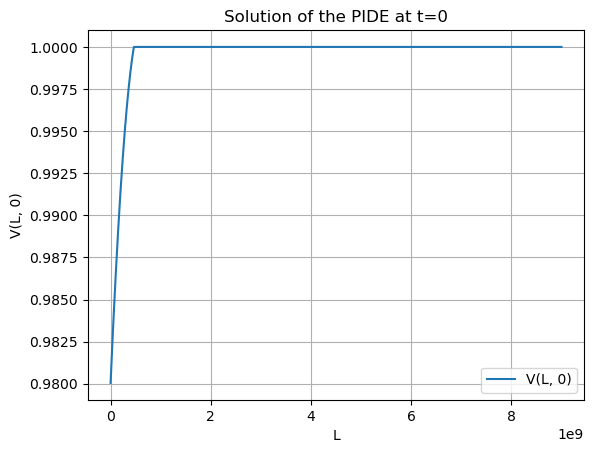

In [231]:
# Parameters
T = 2.0             # Final time
D = 9e9             # Default threshold
lam = 35       # Constant intensity

NT, NL, Nx = 200, 1000, 10000  # Time and space steps
dL = D / NL
dt = T / NT

L_grid = np.linspace(0, D, NL + 1)
t_grid = np.linspace(0, T, NT + 1)

# Gamma distribution parameters
k = 1
th = 1.635e8


# === Initialize V(L, t) ===
V = np.zeros((NL + 1, NT + 1))
V[:, -1] = 0.0

#Jump size distribution
f = lambda l: gamma.pdf(l, a=k, scale=th)
F = lambda l: gamma.cdf(l, a=k, scale=th)

# === Backward time stepping ===
for n in reversed(range(NT)):
    t = t_grid[n]
    
    for i, L in enumerate(L_grid):

        if L > D:
            V[i, n] = 0.0
            continue

        # === Term 1 ===
        term1 = lam * V[i, n + 1]

        # === Term 2: jump leads to default ===
        safe_margin = D - L
        term2 = -lam * (1 - F(safe_margin))

        # Term 3: expected contribution from non-default jumps
        l_vals = np.linspace(0, safe_margin, Nx)
        dx = safe_margin / Nx
        V_interp = np.interp(L + l_vals, L_grid, V[:, n + 1], left=0.0, right=0.0)
        integrand = np.sum(V_interp * f(l_vals)) * dx
        term3 = -lam * integrand

        dVdt = term1 + term2 + term3
        V[i, n] = V[i, n+1] - dt * dVdt
        V[i, n] = np.clip(V[i, n], 0.0, 1.0)


prob_no_default = gamma.cdf(D, a=lam*T*k, scale=th)
print(f"Probability of no default: {prob_no_default:.4f}")

print(V[0,0])

# Plot V(L, 0)
plt.plot(L_grid, V[:, 0], label='V(L, 0)')
plt.xlabel('L')
plt.ylabel('V(L, 0)')
plt.title('Solution of the PIDE at t=0')
plt.grid()
plt.legend()
plt.show()

In [151]:
def solve_pide(D, lam, NT, NL, Nx, k, th, T):
    dL = D / NL
    dT = T / NT

    L_grid = np.linspace(0, D, NL + 1)
    t_grid = np.linspace(0, T, NT + 1)

    # Initialize V(L, t)
    V = np.zeros((NL + 1, NT + 1))
    V[:, -1] = 0.0

    # Jump size distribution
    f = lambda l: gamma.pdf(l, a=k, scale=th)
    F = lambda l: gamma.cdf(l, a=k, scale=th)

    # Backward time stepping
    for n in reversed(range(NT)):
        for i, L in enumerate(L_grid):

            if L >= D:
                V[i, n] = 0.0
                continue

            # Term 1: continuation
            term1 = lam * V[i, n + 1]

            # Term 2: jump causes default
            safe_margin = D - L
            term2 = -lam * (1 - F(safe_margin))

            # Term 3: expected continuation value of non-default jumps
            l_vals = np.linspace(0, safe_margin, Nx)
            dx = safe_margin / Nx
            V_interp = np.interp(L + l_vals, L_grid, V[:, n + 1], left=0.0, right=0.0)
            integrand = np.sum(V_interp * f(l_vals)) * dx
            term3 = -lam * integrand

            dVdT = term1 + term2 + term3
            V[i, n] = V[i, n + 1] - dT * dVdT
            V[i, n] = np.clip(V[i, n], 0.0, 1.0)

    return V[0,0]


In [153]:
# Zero-coupon CAT bond pricing under IS
def CAT_ZC_PIDE(D, lam, T):
    return ZC_Vasicek(F, r, kappa, theta, sigma, t, T)*(1-solve_pide(D, lam, NT, NL, Nx, k, th, T))

In [155]:
# CAT bond with coupons pricing
def CAT_C_PIDE(D, lam, N, T):
    c_sum = 0
    dt = T/N

    for coupon_count in range (N):
        c_sum += ZC_Vasicek(F*c, r, kappa, theta, sigma, t, T=(coupon_count+1)*dt)*(1-solve_pide(D, lam, NT, NL, Nx, k, th, T=(coupon_count+1)*dt))
        
    c_sum = c_sum + ZC_Vasicek(F, r, kappa, theta, sigma, t, T)*(1-solve_pide(D, lam, NT, NL, Nx, k, th, T))
    return c_sum

In [236]:
# Parameter ranges
F = 1  # Fixed face value
t = 0     # Fixed initial time
k = 1     # Fixed Gamma shape
th = 163500000    # Fixed Gamma scale
c=0.05
r=0.03
kappa=0.2
theta=0.03
sigma=0.02
NT=200 
NL=1000
Nx=10000

D=9e9
lam=35
N=0
T=1

num_runs = 1  # Number of iterations
results = []  # Store function outputs

start_time = time.time()  # Start timing

for _ in range(num_runs):
    result = CAT_ZC_PIDE(D, lam, T)  # Run the function
    results.append(result)  # Store the result

end_time = time.time()  # End timing

# Compute statistics
total_time_PIDE = end_time - start_time  # Total execution time
prediction_PIDE = np.mean(results)  # Mean of the function outputs

# Print results
print("Prediction:", prediction_PIDE)
print(f"Time taken for prediction: {total_time_PIDE:.6f} seconds")

Prediction: 0.959195795480818
Time taken for prediction: 53.999318 seconds


In [237]:
N=2
T=1

results = []  # Store function outputs

start_time = time.time()  # Start timing

for _ in range(num_runs):
    result = CAT_C_PIDE(D, lam, N, T)  # Run the function
    results.append(result)  # Store the result

end_time = time.time()  # End timing

# Compute statistics
total_time_PIDE = end_time - start_time  # Total execution time
prediction_PIDE = np.mean(results)  # Mean of the function outputs

# Print results
print("Prediction:", prediction_PIDE)
print(f"Time taken for prediction: {total_time_PIDE:.6f} seconds")

Prediction: 1.0564115103949463
Time taken for prediction: 158.174243 seconds


In [238]:
N=4
T=1

results = []  # Store function outputs

start_time = time.time()  # Start timing

for _ in range(num_runs):
    result = CAT_C_PIDE(D, lam, N, T)  # Run the function
    results.append(result)  # Store the result

end_time = time.time()  # End timing

# Compute statistics
total_time_PIDE = end_time - start_time  # Total execution time
prediction_PIDE = np.mean(results)  # Mean of the function outputs

# Print results
print("Prediction:", prediction_PIDE)
print(f"Time taken for prediction: {total_time_PIDE:.6f} seconds")

Prediction: 1.1549108597898063
Time taken for prediction: 264.460663 seconds


In [240]:
N=8
T=2

results = []  # Store function outputs

start_time = time.time()  # Start timing

for _ in range(num_runs):
    result = CAT_C_PIDE(D, lam, N, T)  # Run the function
    results.append(result)  # Store the result

end_time = time.time()  # End timing

# Compute statistics
total_time_PIDE = end_time - start_time  # Total execution time
prediction_PIDE = np.mean(results)  # Mean of the function outputs

# Print results
print("Prediction:", prediction_PIDE)
print(f"Time taken for prediction: {total_time_PIDE:.6f} seconds")

Prediction: 0.3146402203817224
Time taken for prediction: 472.816298 seconds


In [241]:
N=12
T=2

results = []  # Store function outputs

start_time = time.time()  # Start timing

for _ in range(num_runs):
    result = CAT_C_PIDE(D, lam, N, T)  # Run the function
    results.append(result)  # Store the result

end_time = time.time()  # End timing

# Compute statistics
total_time_PIDE = end_time - start_time  # Total execution time
prediction_PIDE = np.mean(results)  # Mean of the function outputs

# Print results
print("Prediction:", prediction_PIDE)
print(f"Time taken for prediction: {total_time_PIDE:.6f} seconds")

Prediction: 0.4677796884966927
Time taken for prediction: 684.587776 seconds
